In [1]:
!pip3 install /home/Christoph/Documents/PublicRepos/AFC

Processing /home/Christoph/Documents/PublicRepos/AFC
  Preparing metadata (setup.py) ... done
  Created wheel for AFC: filename=AFC-0.0.1-py3-none-any.whl size=27690 sha256=e92b76115b9e334fa2f78520590abd7e1e3a7da4ae4a0807e8e02b18e0460026
  Stored in directory: /tmp/pip-ephem-wheel-cache-6u9a3q9n/wheels/0a/77/33/61b5888c3493ec3b0b17061e1f876dfa3e9d086aa1f01d0031
Successfully built AFC
  Attempting uninstall: AFC
    Found existing installation: AFC 0.0.1
    Uninstalling AFC-0.0.1:
      Successfully uninstalled AFC-0.0.1
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/usr/local/lib/python3.8/dist-packages/pip/_vendor/rich/console.py", line 1390, in rend

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:

from afc.utility.weather import read_tmy3

# Append DOPER to directory
# sys.path.append(r'C:\Users\Christoph\Documents\PrivateRepos\doper_private')
# sys.path.append(r'C:\Users\Christoph\Documents\DynamicFacades\doper_private')
# sys.path.append(r'/home/christoph/Documents/DynamicFacades/doper_private')
# sys.path.append(r'C:\Users\Christoph\Documents\PrivateRepos\doper_private\DOPER')
# sys.path.append(r'C:\Users\Christoph\Documents\DynamicFacades\doper_private\DOPER')
# sys.path.append(r'/home/christoph/Documents/DynamicFacades/doper_private/DOPER')
# solver_dir = 'solvers'

from doper.data.tariff import get_e19_2020_tariff
from doper.examples import ts_inputs, default_parameter #example_inputs


from doper import DOPER, get_solver, get_root, standard_report
from doper.models.basemodel import base_model, default_output_list
# from doper.models.battery import add_battery
# from doper.example import parameter_add_battery, ts_inputs, default_parameter
# from doper.plotting import plot_dynamic

In [4]:
# # Append legacy plotting
# sys.path.append(r'C:\Users\Christoph\Documents\PrivateRepos\DynamicFacades\emulator')
# sys.path.append(r'C:\Users\Christoph\Documents\DynamicFacades\emulator')
# sys.path.append(r'/home/christoph/Documents/DynamicFacades/emulator')

# from results.AnalyzeEmulator_V3 import plot_statistics1, plot_standard1, plot_tuning1, plot_projected1, plot_plot_xy
# from results.AnalyzeEmulator_V3 import calculateenergycost, cost_comparison

In [5]:
# For testing
from doper.computetariff import compute_periods
#from example import dafault_parameter_laafb_report1, example_inputs_laafb_report1

In [6]:
root = os.getcwd()
# #sys.path.append(os.path.dirname(root))
# sys.path.append(os.path.join(os.path.dirname(os.path.dirname(root)), 'emulator', 'emulator'))
# #from tariff import get_e19_2019_tariff

In [7]:
root

'/home/Christoph/Documents/PublicRepos/AFC/dev'

### Development

### optModel.py

In [52]:
#!/usr/bin/env python

'''
    INTERNAL USE ONLY
    Module of DOPER package (v1.0)
    cgehbauer@lbl.gov

    Version info (v1.0):
        -) Initial disaggregation of old code.
'''

import os
import sys
import itertools
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from pyomo.environ import Objective, minimize, Piecewise
from pyomo.environ import ConcreteModel, Set, Param, Var, Constraint, Binary, Integers

from doper import DOPER, pandas_to_dict, pyomo_read_parameter, get_solver, standard_report
from doper.models.basemodel import base_model #, convert_base_model
from doper.models.battery import add_battery #, convert_battery

# Define if binaries (Mixed-Integer) variables are used.
#use_binary = True

try:
    from .rcModel import R2C2, R4C2, R5C3, R6C3
except:
    sys.path.append(os.path.join('..', 'afc'))
    from rcModel import R2C2, R4C2, R5C3, R6C3

def control_model(inputs, parameter):
    model = base_model(inputs, parameter)#, internal_load=(None, None))
    #model = add_battery(model, inputs, parameter)
    
    inputs = inputs.copy(deep=True)
    if type(inputs.index[0]) == type(pd.to_datetime(0)):
        inputs.index = inputs.index.astype(int)/1000000000 # Convert datetime to UNIX
    #timestep = model.timestep
    #timestep_scale = model.timestep_scale
        
    model.fzones = Set(initialize=parameter['facade']['windows'], doc='window zones')
    model.fstates = Set(initialize=parameter['facade']['states'], doc='facade states')
    model.fstate_bin = Var(model.ts, model.fzones, model.fstates, domain=Binary, doc='facade binary')
    # Thermal Comfort
    model.temps = Set(initialize=range(len(parameter['zone']['temps_name'])), doc='zone temperatures')
    model.zone_temp = Var(model.ts, model.temps, doc='temperature in zone')
    model.zone_heat = Var(model.ts, model.temps, bounds=(0, None), doc='heating in zone')
    model.zone_cool = Var(model.ts, model.temps, bounds=(0, None), doc='cooling in zone')    
    model.zone_temp_max = Param(model.ts, model.temps, \
                                initialize=pandas_to_dict(inputs[['temp_{!s}_max'.format(b) for b in \
                                                                  parameter['zone']['temps_name']]] ,\
                                                          columns=model.temps), \
                                doc='maximal temperatures')
    model.zone_temp_min = Param(model.ts, model.temps, \
                                initialize=pandas_to_dict(inputs[['temp_{!s}_min'.format(b) for b in \
                                                                  parameter['zone']['temps_name']]] ,\
                                                          columns=model.temps), \
                                doc='minimal temperatures')

    
    # Facade loopup table
    fmap = list(itertools.product(model.fzones, model.fstates))
    tfmap = list(itertools.product(model.accounting_ts, model.fzones))
    model.facade_wpi = Param(model.ts, model.fzones, model.fstates, 
                             initialize=pandas_to_dict(inputs[['wpi_{!s}_{!s}'.format(z, s) for z, s in fmap]] ,\
                                                       columns=fmap), \
                             doc='facade wpi lookup table')
    if parameter['zone']['param']['type'] == 'R2C2':
        model.facade_shg = Param(model.ts, model.fzones, model.fstates, 
                                 initialize=pandas_to_dict(inputs[['shg_{!s}_{!s}'.format(z, s) for z, s in fmap]] ,\
                                                           columns=fmap), \
                                 doc='facade shg lookup table')
    model.facade_vil = Param(model.ts, model.fzones, model.fstates, 
                             initialize=pandas_to_dict(inputs[['ev_{!s}_{!s}'.format(z, s) for z, s in fmap]] ,\
                                                       columns=fmap), \
                             doc='facade vil lookup table')
    model.facade_abs1 = Param(model.ts, model.fzones, model.fstates, 
                              initialize=pandas_to_dict(inputs[['abs1_{!s}_{!s}'.format(z, s) for z, s in fmap]] ,\
                                                        columns=fmap), \
                              doc='facade abs1 lookup table')
    model.facade_abs2 = Param(model.ts, model.fzones, model.fstates, 
                              initialize=pandas_to_dict(inputs[['abs2_{!s}_{!s}'.format(z, s) for z, s in fmap]] ,\
                                                        columns=fmap), \
                              doc='facade abs2 lookup table')
    model.facade_tsol = Param(model.ts, model.fzones, model.fstates, 
                              initialize=pandas_to_dict(inputs[['tsol_{!s}_{!s}'.format(z, s) for z, s in fmap]] ,\
                                                        columns=fmap), \
                              doc='facade tsol lookup table')
    model.facade_iflr = Param(model.ts, model.fzones, model.fstates, 
                              initialize=pandas_to_dict(inputs[['iflr_{!s}_{!s}'.format(z, s) for z, s in fmap]] ,\
                                                        columns=fmap), \
                              doc='facade iflr lookup table')
    model.wpi_constraint_min = Param(model.ts, initialize=pandas_to_dict(inputs['wpi_min']), \
                                     doc='constraint for wpi lookup table')
    model.glare_constraint_max = Param(model.ts, initialize=pandas_to_dict(inputs['glare_max']), \
                                       doc='constraint for glare lookup table')
    
    # Facade model
    model.zone_wpi = Var(model.ts, doc='wpi in zone')
    model.zone_shg = Var(model.ts, doc='shg in zone')
    model.zone_vil = Var(model.ts, doc='vil in zone')
    model.zone_abs1 = Var(model.ts, doc='abs1 in zone')
    model.zone_abs2 = Var(model.ts, doc='abs2 in zone')
    model.zone_tsol = Var(model.ts, doc='tsol in zone')
    model.zone_iflr = Var(model.ts, doc='iflr in zone')
    model.fstate = Var(model.ts, model.fzones, doc='facade state')
    model.der_fstate = Var(model.ts, model.fzones, doc='facade state')
    # Precompute
    inputs['how1'] = 1 / (parameter['facade']['window_area'] * \
                          (parameter['facade']['convection_window_offset'] \
                           + parameter['facade']['convection_window_scale'] \
                           * inputs['wind_speed']))
    model.how1 = Param(model.ts, initialize=pandas_to_dict(inputs['how1']), \
                       doc='window heat transfer rate [K/W]')
    
    def fstate_unique(model, ts, fzone):
        return 1 == sum(model.fstate_bin[ts, fzone, s] for s in model.fstates)
    model.constraint_fstate_unique = Constraint(model.ts, model.fzones, rule=fstate_unique, doc='calculation of wpi') 
        
    def zone_wpi(model, ts):
        return model.zone_wpi[ts] == sum(model.facade_wpi[ts, z, s] * model.fstate_bin[ts, z, s] for z, s in fmap)
    model.constraint_zone_wpi = Constraint(model.ts, rule=zone_wpi, doc='calculation of wpi')
        
    if parameter['zone']['param']['type'] == 'R2C2':
        def zone_shg(model, ts):
            return model.zone_shg[ts] == sum(model.facade_shg[ts, z, s] * model.fstate_bin[ts, z, s] for z, s in fmap)
        model.constraint_zone_shg = Constraint(model.ts, rule=zone_shg, doc='calculation of shg')
        
    def zone_vil(model, ts):
        return model.zone_vil[ts] == sum(model.facade_vil[ts, z, s] * model.fstate_bin[ts, z, s] for z, s in fmap)
    model.constraint_zone_vil = Constraint(model.ts, rule=zone_vil, doc='calculation of vil')

    def zone_abs1(model, ts):
        return model.zone_abs1[ts] == sum(model.facade_abs1[ts, z, s] * model.fstate_bin[ts, z, s] for z, s in fmap)
    model.constraint_zone_abs1 = Constraint(model.ts, rule=zone_abs1, doc='calculation of abs1')
    
    def zone_abs2(model, ts):
        return model.zone_abs2[ts] == sum(model.facade_abs2[ts, z, s] * model.fstate_bin[ts, z, s] for z, s in fmap)
    model.constraint_zone_abs2 = Constraint(model.ts, rule=zone_abs2, doc='calculation of abs2')
    
    def zone_tsol(model, ts):
        return model.zone_tsol[ts] == sum(model.facade_tsol[ts, z, s] * model.fstate_bin[ts, z, s] for z, s in fmap)
    model.constraint_zone_tsol = Constraint(model.ts, rule=zone_tsol, doc='calculation of tsol')
    
    def zone_iflr(model, ts):
        return model.zone_iflr[ts] == sum(model.facade_iflr[ts, z, s] * model.fstate_bin[ts, z, s] for z, s in fmap)
    model.constraint_zone_iflr= Constraint(model.ts, rule=zone_iflr, doc='calculation of iflr')
    
    def fstate(model, ts, zone):     
        return model.fstate[ts, zone] == sum(s * model.fstate_bin[ts, zone, s] for s in model.fstates)
    model.constraint_fstate = Constraint(model.ts, model.fzones, rule=fstate, doc='calculation of fstate')
    
    def der_fstate(model, ts, zone):
        if ts == model.ts.at(1): return model.der_fstate[ts, zone] == 0
        else: return model.der_fstate[ts, zone] == model.fstate[ts, zone] - model.fstate[ts-model.timestep[ts], zone]
    model.constraint_der_fstate = Constraint(model.ts, model.fzones, rule=der_fstate, doc='calculation of der_fstate')
    
    # Visual Comfort
    model.zone_wpi_total = Var(model.ts, doc='total wpi in zone')
    model.zone_wpi_ext = Var(model.ts, bounds=(0, parameter['zone']['lighting_capacity']), doc='artificial lighting lx')
    model.zone_lights_bin = Var(model.ts, domain=Binary, doc='lights binary')
    model.zone_glare = Var(model.ts, doc='glare in zone')
    model.zone_glare_penalty = Var(model.ts, bounds=(0, None), doc='glare penalty in zone')    
    model.sum_glare_penalty = Var(bounds=(0, None), doc='sum of glare penalty in zone')
    model.zone_view_penalty = Var(model.ts, bounds=(0, None), doc='view penalty in zone')    
    model.sum_view_penalty = Var(bounds=(0, None), doc='sum of view penalty in zone')
    model.zone_actuation = Var(model.ts, doc='actuation in zone')
    model.zone_actuation_pos = Var(model.ts, model.fzones, bounds=(0, None), doc='positive actuation in zone')
    model.zone_actuation_neg = Var(model.ts, model.fzones, bounds=(0, None), doc='negativ actuation in zone') 
    model.zone_abs_actuation = Var(model.ts, doc='absolute actuation in zone')
    model.sum_zone_actuation = Var(bounds=(0, None), doc='sum of actuation in zone')
    
    def zone_wpi_total(model, ts):
        return model.zone_wpi_total[ts] == model.zone_wpi[ts] + model.zone_wpi_ext[ts]
    model.constraint_zone_wpi_total = Constraint(model.ts, rule=zone_wpi_total, doc='total wpi calculation')   
    
    def ctrl_lights_1(model, ts):
        return model.zone_wpi_ext[ts] <= model.zone_lights_bin[ts] * 1e3
    model.constraint_ctrl_lights_1 = Constraint(model.ts, rule=ctrl_lights_1, doc='Avoid heat with lights')
   
    def ctrl_lights_2(model, ts):
        return model.zone_wpi[ts] - model.wpi_constraint_min[ts] <= (1 - model.zone_lights_bin[ts]) * 1e5
    model.constraint_ctrl_lights_2 = Constraint(model.ts, rule=ctrl_lights_2, doc='Avoid heat with lights')
    
    def ctrl_lights_3(model, ts):
        return model.zone_wpi_ext[ts] - model.wpi_constraint_min[ts] - model.zone_wpi[ts] <= (1 - model.zone_lights_bin[ts]) * 1e5
    model.constraint_ctrl_lights_3 = Constraint(model.ts, rule=ctrl_lights_3, doc='Avoid heat with lights')
    
    def zone_wpi_min(model, ts):
        return model.zone_wpi_total[ts] >= model.wpi_constraint_min[ts]
    model.constraint_zone_wpi_min = Constraint(model.ts, rule=zone_wpi_min, doc='limit wpi')   

    def zone_glare(model, ts):
        return model.zone_glare[ts] == model.zone_vil[ts] * 6.22e-5 + 0.184
    model.constraint_zone_glare = Constraint(model.ts, rule=zone_glare, doc='calculation of glare')
    
    def zone_limit_glare(model, ts):
        return model.zone_glare[ts] <= model.glare_constraint_max[ts]
    model.constraint_zone_limit_glare = Constraint(model.ts, rule=zone_limit_glare, doc='limit glare')   
    
    def zone_glare_penalty(model, ts):
        return model.zone_glare_penalty[ts] >= (model.zone_glare[ts] \
                                                - (model.glare_constraint_max[ts] \
                                                   - parameter['zone']['glare_diff'])) \
                                               * parameter['zone']['glare_scale']
    model.constraint_zone_glare_penalty = Constraint(model.ts, rule=zone_glare_penalty, doc='calculation of glare penalty')
    
    def sum_glare_penalty(model):
        return model.sum_glare_penalty == sum(model.zone_glare_penalty[t] for t in model.accounting_ts)
    model.constraint_sum_glare_penalty = Constraint(rule=sum_glare_penalty, doc='calcualtion of sum glare penalty')
    
    def zone_view_penalty(model, ts, fzone):
        return model.zone_view_penalty[ts] >= (- model.fstate[ts, fzone] \
                                               + max(parameter['facade']['states'])) \
                                              * parameter['zone']['view_scale']
    model.constraint_zone_view_penalty = Constraint(model.ts, model.fzones, rule=zone_view_penalty, doc='calculation of view penalty')
    
    def sum_view_penalty(model):
        return model.sum_view_penalty == sum(model.zone_view_penalty[t] for t in model.accounting_ts)
    model.constraint_sum_view_penalty = Constraint(rule=sum_view_penalty, doc='calcualtion of sum view penalty')

    def zone_actuation(model, ts):
        return model.zone_actuation[ts] == sum(model.der_fstate[ts, z] for z in model.fzones)
    model.constraint_zone_actuation = Constraint(model.ts, rule=zone_actuation, doc='calcualtion of actuation')
    
    def zone_actuation_pos(model, ts, fzone):
        return model.zone_actuation_pos[ts, fzone] >= model.der_fstate[ts, fzone]
    model.constraint_zone_actuation_pos = Constraint(model.ts, model.fzones, rule=zone_actuation_pos, doc='calcualtion of pos actuation')
    
    def zone_actuation_neg(model, ts, fzone):
        return model.zone_actuation_neg[ts, fzone] >= -1 * model.der_fstate[ts, fzone]
    model.constraint_zone_actuation_neg = Constraint(model.ts, model.fzones, rule=zone_actuation_neg, doc='calcualtion of neg actuation')
    
    def zone_abs_actuation(model, ts):
        return model.zone_abs_actuation[ts] == sum(model.zone_actuation_pos[ts, z] \
                                                    + model.zone_actuation_neg[ts, z] for z in model.fzones)
    model.constraint_zone_abs_actuation = Constraint(model.ts, rule=zone_abs_actuation, doc='calcualtion of abs actuation')

    def zone_sum_actuation(model):
        return model.sum_zone_actuation == sum(model.zone_abs_actuation[t] for t in model.accounting_ts)
    model.constraint_zone_sum_actuation = Constraint(rule=zone_sum_actuation, doc='calcualtion of sum actuation')
    
    '''
    def zone_fstate_night(model, ts, fzone):
        if parameter['facade']['type'] == 'shade':
            return model.fstate[ts, fzone] <= min(parameter['facade']['states']) + model.zone_wpi[ts]
        else:
            return model.fstate[ts, fzone] >= max(parameter['facade']['states']) - model.zone_wpi[ts]
    model.constraint_zone_fstate_night = Constraint(model.ts, model.fzones, rule=zone_fstate_night, doc='clear fstate at night')
    '''
    
    ix_night = inputs.index[inputs[[c for c in inputs.columns \
                                    if ('wpi_' in c or 'tsol_' in c) and not 'min' in c]].sum(axis=1) == 0]
    bin_clear = [0]*(len(model.fstates)-1)+[1]
    bin_fixed = [True]*len(model.fstates)
    for ts in ix_night:
        for fzone in model.fzones:
            for s in model.fstates:
                model.fstate_bin[ts, fzone, s] = bin_clear[s]
                model.fstate_bin[ts, fzone, s].fixed = bin_fixed[s]
    
    
    # Electricity
    model.p = Var(model.ts, doc='total electric power')
    model.p_lights = Var(model.ts, doc='electric power of lights')
    model.p_heating = Var(model.ts, doc='electric power of heating')
    model.p_cooling = Var(model.ts, doc='electric power of cooling')
    model.p_equipment = Param(model.ts, initialize=pandas_to_dict(inputs['equipment']), \
                             doc='electric equipment load in room')
    model.zone_plugload = Param(model.ts, initialize=pandas_to_dict(inputs['plug_load']), \
                                doc='thermal plugloads in room')
    model.zone_occload = Param(model.ts, initialize=pandas_to_dict(inputs['occupant_load']), \
                               doc='thermal occupant load in room')
            
    def zone_p(model, ts):
        return model.p[ts] == model.p_lights[ts] + model.p_heating[ts] + model.p_cooling[ts] + model.p_equipment[ts]
    model.constraint_zone_p = Constraint(model.ts, rule=zone_p, doc='electric power of zone')     
    
    def zone_p_lights(model, ts):
        return model.p_lights[ts] == model.zone_wpi_ext[ts] * parameter['zone']['lighting_efficiency']
    model.constraint_zone_p_lights = Constraint(model.ts, rule=zone_p_lights, doc='electric power of lights')   
    
    def zone_p_heat(model, ts):
        return model.p_heating[ts] == sum(model.zone_heat[ts, temps] for temps in model.temps) \
                                      * parameter['zone']['heating_efficiency']
    model.constraint_zone_p_heat = Constraint(model.ts, rule=zone_p_heat, doc='electric power of heating') 
    
    def zone_p_cool(model, ts):
        return model.p_cooling[ts] == sum(model.zone_cool[ts, temps] for temps in model.temps) \
                                      * parameter['zone']['cooling_efficiency']
    model.constraint_zone_p_cool = Constraint(model.ts, rule=zone_p_cool, doc='electric power of cooling')  
    
    # Integration in model (at node 0 only)
    def zone_total_load(model, ts, node):
        if node == model.nodes.at(parameter['zone']['zone_id']):
            return model.building_load_dynamic[ts, node] == (model.p[ts]) / 1e3
        else:
            return model.building_load_dynamic[ts, node] == 0
    model.constraint_zone_total_load = Constraint(model.ts, model.nodes, rule=zone_total_load, doc='total electric power to link models')
    
    def zone_total_load_end(model, ts, node):
        if ts == model.ts.at(len(model.ts)):
            return model.building_load_dynamic[ts, node] == model.building_load_dynamic[ts-model.timestep[ts], node]
        else:
            return model.building_load_dynamic[ts, node] >= -9e6
    model.constraint_zone_total_load_end = Constraint(model.ts, model.nodes, rule=zone_total_load_end, doc='fix last timestep')                                                                        
    
    
    # Thermal Comfort
    model.zone_qi = Var(model.ts, doc='convective gains in zone')
    model.zone_qw = Var(model.ts, doc='gains in wall (radiative) in zone')
    model.zone_qs = Var(model.ts, doc='gains in slab (radiative) in zone')
    
    def zone_qi(model, ts):
        param = parameter['zone']['param']
        Qi_ext = model.p_lights[ts] * (1 - parameter['zone']['lighting_split']) \
                 + model.zone_occload[ts] * (1 - parameter['zone']['occupancy_split']) \
                 + model.zone_plugload[ts] * (1 - parameter['zone']['plugload_split']) \
                 + model.zone_heat[ts, 0] - model.zone_cool[ts, 0]
        if param['type'] == 'R2C2':
            Qi_ext += model.zone_shg[ts] * (1 - parameter['zone']['shg_split'])
        else:
            Qi_ext += model.zone_tsol[ts] * (1 - parameter['zone']['tsol_split'])
        return model.zone_qi[ts] == Qi_ext
    model.constraint_zone_qi = Constraint(model.ts, rule=zone_qi, doc='calculaiton convective')
    
    def zone_qw(model, ts):
        param = parameter['zone']['param']
        Qw_ext = model.p_lights[ts] * parameter['zone']['lighting_split'] \
                 + model.zone_occload[ts] * parameter['zone']['occupancy_split'] \
                 + model.zone_plugload[ts] * parameter['zone']['plugload_split']
        if param['type'] == 'R2C2':
            Qw_ext += model.zone_shg[ts] * parameter['zone']['shg_split']
        else:
            Qw_ext += model.zone_tsol[ts] * parameter['zone']['tsol_split']
        return model.zone_qw[ts] == Qw_ext
    model.constraint_zone_qw = Constraint(model.ts, rule=zone_qw, doc='calculaiton radiative gains wall')
    
    def zone_qs(model, ts):
        return model.zone_qs[ts] == model.zone_iflr[ts]
    model.constraint_zone_qs = Constraint(model.ts, rule=zone_qs, doc='calculaiton radiative gains slab')
       
    def zone_temp(model, ts, temps):
        if ts == model.ts.at(1):
            return model.zone_temp[ts, temps] == parameter['zone']['temps_initial'][temps]
        else:
            Ti_p = model.zone_temp[ts-model.timestep[ts], 0]
            Ts_p = model.zone_temp[ts-model.timestep[ts], 1]
            To = model.outside_temperature[ts-model.timestep[ts]]
            Qi_ext = model.zone_qi[ts-model.timestep[ts]]
            Qw_ext = model.zone_qw[ts-model.timestep[ts]]            
            param = parameter['zone']['param'].copy()
            param['timestep'] = model.timestep[ts]
            if param['type'] == 'R2C2':
                res_temps = R2C2(1, Ti_p, Ts_p, To, Qi_ext, Qw_ext, param)
            elif param['type'] in ['R4C2', 'R5C3', 'R6C3']:
                Qw1_ext = model.zone_abs1[ts-model.timestep[ts]]
                Qw2_ext = model.zone_abs2[ts-model.timestep[ts]]
                Qs_ext = model.zone_qs[ts-model.timestep[ts]]
                if param['type'] == 'R4C2':
                    Qi_ext = Qi_ext + Qw_ext - Qs_ext
                    Qw_ext = Qs_ext
                    res_temps = R4C2(1, Ti_p, Ts_p, To, Qw1_ext, Qw2_ext, Qi_ext, Qw_ext, param)
                elif param['type'] == 'R5C3':
                    Tw_p = model.zone_temp[ts-model.timestep[ts], 2]
                    Qw_ext = Qw_ext - Qs_ext
                    res_temps = R5C3(1, Ti_p, Ts_p, Tw_p, To, Qw1_ext, Qw2_ext, Qi_ext, Qs_ext, Qw_ext, param)
                elif param['type'] == 'R6C3':
                    Tw_p = model.zone_temp[ts-model.timestep[ts], 2]
                    Qw_ext = Qw_ext - Qs_ext
                    param['Row1'] = param['Row1'] * model.how1[ts]
                    res_temps = R6C3(1, Ti_p, Ts_p, Tw_p, To, Qw1_ext, Qw2_ext, Qi_ext, Qs_ext, Qw_ext, param)
            else:
                raise ValueError('RC model type {} not supported.'.format(param['type']))
            return model.zone_temp[ts, temps] == res_temps[temps]
    model.constraint_zone_temp = Constraint(model.ts, model.temps, rule=zone_temp, doc='calculaiton of temperature')
    
    def zone_heating_limit(model, ts, temps):
        return model.zone_heat[ts, temps] <= parameter['zone']['heat_max'][temps]
    model.constraint_zone_heating_limit = Constraint(model.ts, model.temps, rule=zone_heating_limit, doc='limit of heating')
    
    def zone_cooling_limit(model, ts, temps):
        return model.zone_cool[ts, temps] <= parameter['zone']['cool_max'][temps]
    model.constraint_zone_cooling_limit = Constraint(model.ts, model.temps, rule=zone_cooling_limit, doc='limit of cooling')
    
    def zone_max_temperature(model, ts, temps):
        if ts == model.ts.at(-1):
            return model.zone_temp[ts, temps] <= 1e6
        else:
            return model.zone_temp[ts, temps] <= model.zone_temp_max[ts-model.timestep[ts], temps]
    model.constraint_zone_max_temperature = Constraint(model.ts, model.temps, rule=zone_max_temperature, doc='max temperature')
    
    def zone_min_temperature(model, ts, temps):
        if ts == model.ts.at(-1):
            return model.zone_temp[ts, temps] <= 1e6
        else:
            return model.zone_temp[ts, temps] >= model.zone_temp_min[ts-model.timestep[ts], temps]
    model.constraint_zone_min_temperature = Constraint(model.ts, model.temps, rule=zone_min_temperature, doc='min temperature')
    
    
    

    

    
    

    if 'weight_degradation' in parameter['objective']:
        print('WARNING: No "degradation" in objective function.')
    def objective_function(model):
        return model.sum_energy_cost * parameter['objective']['weight_energy'] \
               + model.sum_demand_cost * parameter['objective']['weight_demand'] \
               + model.sum_export_revenue * parameter['objective']['weight_export'] \
               + model.sum_zone_actuation * parameter['objective']['weight_actuation'] \
               + model.sum_glare_penalty * parameter['objective']['weight_glare'] \
               + model.sum_view_penalty * parameter['objective']['weight_view']
               #+ model.sum_regulation_revenue * parameter['objective']['weight_regulation']
    model.objective = Objective(rule=objective_function, sense=minimize, doc='objective function')
    return model

def convert_facades_model(model, parameter, old_names=False):   
    
    columns = ['Window Illuminance [lx]','Artificial Illuminance [lx]','Power Lights [W]','Solar Heat Gain [W]', \
               'Glare [-]','Room Temperature [C]','Slab Temperature [C]','Outside Air Temperature [C]', \
               'Power Heating [W]','Power Cooling [W]','Room Temperature Max [C]','Slab Temperature Max [C]', \
               'Room Temperature Min [C]','Slab Temperature Min [C]', \
               'Actuation [-]','Actuation Abs [-]','Glare Max [-]','Glare Penalty [-]','View Penalty [-]', \
               'Work Plane Illuminance Min [lx]','Power Plugs [W]','Power Occupancy [W]','Work Plane Illuminance [lx]', \
               'Window Absorption 1 [W]','Window Absorption 2 [W]','Window Transmitted Solar [W]',\
               'Convective Internal Gains [W]','Radiative Slab Gains [W]','Radiative Wall Gains [W]', \
               'Power Equipment [W]']
    if model.fzones[-1] == 2 and old_names:
        columns += ['Tint Bottom [-]','Tint Middle [-]','Tint Top [-]']
    else:
        for z in model.fzones:
            columns += ['Facade State {}'.format(z)]
    if parameter['zone']['param']['type'] in ['R5C3', 'R6C3']:
        columns += ['Wall Temperature [C]','Wall Temperature Max [C]','Wall Temperature Min [C]']
        
    df = {}
    for t in model.ts:
        df[t] = [model.zone_wpi[t].value, model.zone_wpi_ext[t].value, model.p_lights[t].value, model.zone_shg[t].value, \
                 model.zone_glare[t].value, model.zone_temp[t,0].value, model.zone_temp[t,1].value, \
                 model.outside_temperature[t], model.p_heating[t].value, model.p_cooling[t].value, \
                 model.zone_temp_max[t,0], model.zone_temp_max[t,1], model.zone_temp_min[t,0], model.zone_temp_min[t,1], \
                 model.zone_actuation[t].value, \
                 model.zone_abs_actuation[t].value, model.glare_constraint_max[t], model.zone_glare_penalty[t].value, \
                 model.zone_view_penalty[t].value, model.wpi_constraint_min[t], model.zone_occload[t], \
                 model.zone_plugload[t], model.zone_wpi_total[t].value, model.zone_abs1[t].value, \
                 model.zone_abs2[t].value, model.zone_tsol[t].value, model.zone_qi[t].value, model.zone_qs[t].value, \
                 model.zone_qw[t].value, model.p_equipment[t]]
        for z in model.fzones:
            df[t] += [model.fstate[t,z].value]
        if parameter['zone']['param']['type'] in ['R5C3', 'R6C3']:
            df[t] += [model.zone_temp[t,2].value, model.zone_temp_max[t,2], model.zone_temp_min[t,2]]
        # Regulation
        #df[t] += [model.sum_regulation_up[t], model.sum_regulation_dn[t]]
        # Tariff
        #df[t] += [model.tariff_regulation_up[t], model.tariff_regulation_dn[t], model.regulation_revenue[t].value, \
        #          model.energy_cost[t].value, model.energy_export_revenue[t].value]

    df = pd.DataFrame(df).transpose()
    df.columns = columns
    df.index = pd.to_datetime(df.index, unit='s')

    #df['Tariff Energy [$/kWh]'] = df[['Tariff Energy Period [-]']].replace(pyomo_read_parameter(model.tariff_energy))
    return df

def afc_output_list():
    ctrlOutputs = []
    #ctrlOutputs.append({'name': '', 'data', '', 'df_label': ''})
    ctrlOutputs.append({'data': 'zone_wpi', 'df_label': 'Window Illuminance [lx]'})
    ctrlOutputs.append({'data': 'zone_wpi_ext', 'df_label': 'Artificial Illuminance [lx]'})
    ctrlOutputs.append({'data': 'p_lights', 'df_label': 'Power Lights [W]'})
    ctrlOutputs.append({'data': 'zone_shg', 'df_label': 'Solar Heat Gain [W]'})
    ctrlOutputs.append({'data': 'zone_glare', 'df_label': 'Glare [-]'})
    ctrlOutputs.append({'data': 'outside_temperature', 'df_label': 'Outside Air Temperature [C]'})
    ctrlOutputs.append({'data': 'p_heating', 'df_label': 'Power Heating [W]'})
    ctrlOutputs.append({'data': 'p_cooling', 'df_label': 'Power Cooling [W]'})
    ctrlOutputs.append({'data': 'zone_actuation', 'df_label': 'Actuation [-]'})
    ctrlOutputs.append({'data': 'zone_abs_actuation', 'df_label': 'Actuation Abs [-]'})
    ctrlOutputs.append({'data': 'glare_constraint_max', 'df_label': 'Glare Max [-]'})
    ctrlOutputs.append({'data': 'zone_glare_penalty', 'df_label': 'Glare Penalty [-]'})
    ctrlOutputs.append({'data': 'zone_view_penalty', 'df_label': 'View Penalty [-]'})
    ctrlOutputs.append({'data': 'wpi_constraint_min', 'df_label': 'Work Plane Illuminance Min [lx]'})
    ctrlOutputs.append({'data': 'zone_occload', 'df_label': 'Power Occupancy [W]'})
    ctrlOutputs.append({'data': 'zone_plugload', 'df_label': 'Power Plugs [W]'})
    ctrlOutputs.append({'data': 'zone_wpi_total', 'df_label': 'Work Plane Illuminance [lx]'})
    ctrlOutputs.append({'data': 'zone_abs1', 'df_label': 'Window Absorption 1 [W]'})
    ctrlOutputs.append({'data': 'zone_abs2', 'df_label': 'Window Absorption 2 [W]'})
    ctrlOutputs.append({'data': 'zone_tsol', 'df_label': 'Window Transmitted Solar [W]'})
    ctrlOutputs.append({'data': 'zone_qi', 'df_label': 'Convective Internal Gains [W]'})
    ctrlOutputs.append({'data': 'zone_qs', 'df_label': 'Radiative Slab Gains [W]'})
    ctrlOutputs.append({'data': 'zone_qw', 'df_label': 'Radiative Wall Gains [W]'})
    ctrlOutputs.append({'data': 'p_equipment', 'df_label': 'Power Equipment [W]'})
    ctrlOutputs.append({'data': 'fstate', 'df_label': 'Facade State %s', 'index': 'fzones'}) # bm, mid, up
    ctrlOutputs.append({'data': 'zone_temp', 'df_label': 'Temperature %s [C]', 'index': 'temps'}) # room, slab
    ctrlOutputs.append({'data': 'zone_temp_min', 'df_label': 'Temperature %s Min [C]', 'index': 'temps'}) # room, slab
    ctrlOutputs.append({'data': 'zone_temp_max', 'df_label': 'Temperature %s Max [C]', 'index': 'temps'}) # room, slab
    for d in ctrlOutputs:
        d['name'] = d['data']
    return ctrlOutputs

    
def pyomo_to_pandas(model, parameter):
    '''
        Utility to translate optimization output to a dataframe.

        Input
        -----
            model (pyomo.environ.ConcreteModel): The optimized model to be translated.
            parameter (dict): Configuration dictionary for the optimization.

        Returns
        -------
            df (pandas.DataFrame): A dataframe including the results of the optimization.
    '''
    df = convert_base_model(model, parameter)
    df = pd.concat([df, convert_battery(model, parameter)], axis=1)
    df = pd.concat([df, convert_facades_model(model, parameter)], axis=1)
    return df
    
def plot_streams(axs, temp, plot_times=False, title=None, ylabel=None, legend=False, loc=1):
    '''
        Utility to simplify plotting of subplots.

        Input
        -----
            axs (matplotlib.axes._subplots.AxesSubplot): The axis to be plotted.
            temp (pandas.Series): The stream to be plotted.
            plot_times (bool): Flag if time separation should be plotted. (default=True)
    '''
    axs.plot(temp)
    axs.legend(temp.columns, loc=2)
    if plot_times:
        idx0 = temp.index[temp.index.minute==0]
        axs.plot([idx0[idx0.hour==8],idx0[idx0.hour==8]],[temp.values.min(),temp.values.max()], color='orange', linestyle=':')
        axs.plot([idx0[idx0.hour==12],idx0[idx0.hour==12]],[temp.values.min(),temp.values.max()], color='red', linestyle=':')
        axs.plot([idx0[idx0.hour==18],idx0[idx0.hour==18]],[temp.values.min(),temp.values.max()], color='red', linestyle=':')
        axs.plot([idx0[idx0.hour==22],idx0[idx0.hour==22]],[temp.values.min(),temp.values.max()], color='orange', linestyle=':')
        if temp.values.min() < 0 and temp.values.max() > 0:
            axs.plot([idx0[0],idx0[-1]],[0,0], color='black', linestyle=':')
    if title: axs.set_title(title)
    if ylabel: axs.set_ylabel(ylabel)
    if legend: axs.legend(legend, loc=loc)
        
def plot_standard2(df, plot=True, plot_times=True, tight=True):
    '''
        A standard plotting template to present results.

        Input
        -----
            df (pandas.DataFrame): The resulting dataframe with the optimization result.
            plot (bool): Flag to plot or return the figure. (default=True)
            plot_times (bool): Flag if time separation should be plotted. (default=True)
            tight (bool): Flag to use tight_layout. (default=True)
            
        Returns
        -------
            None if plot == True.
            else:
                fig (matplotlib figure): Figure of the plot.
                axs (numpy.ndarray of matplotlib.axes._subplots.AxesSubplot): Axis of the plot.
    '''
    fig, axs = plt.subplots(4,1, figsize=(12, 4*3), sharex=True, sharey=False, gridspec_kw = {'width_ratios':[1]})
    axs = axs.ravel()
    plot_streams(axs[0], df[['Import Power [kW]','Export Power [kW]']], plot_times=plot_times)
    plot_streams(axs[1], df[['Battery Power [kW]','Load Power [kW]','PV Power [kW]','Internal Power [kW]']], plot_times=plot_times)
    plot_streams(axs[2], df[['Tariff Energy [$/kWh]']], plot_times=plot_times)
    plot_streams(axs[3], df[['Battery SOC [-]']], plot_times=plot_times)
    #plot_streams(axs[4], df[['Reg Up [kW]','Reg Dn [kW]']], plot_times=plot_times)
    #plot_streams(axs[5], df[['Tariff Reg Up [$/kWh]','Tariff Reg Dn [$/kWh]']], plot_times=plot_times)
    if plot:
        if tight:
            plt.tight_layout()
        plt.show()
    else: return fig, axs
    
def plot_battery1(df, model, plot=True, tight=True):
    '''
        A standard plotting template to present results.

        Input
        -----
            df (pandas.DataFrame): The resulting dataframe with the optimization result.
            plot (bool): Flag to plot or return the figure. (default=True)
            plot_times (bool): Flag if time separation should be plotted. (default=True)
            tight (bool): Flag to use tight_layout. (default=True)
            
        Returns
        -------
            None if plot == True.
            else:
                fig (matplotlib figure): Figure of the plot.
                axs (numpy.ndarray of matplotlib.axes._subplots.AxesSubplot): Axis of the plot.
    '''
    fig, axs = plt.subplots(5,1, figsize=(12, 5*3), sharex=True, sharey=False, gridspec_kw = {'width_ratios':[1]})
    axs = axs.ravel()
    plot_streams(axs[0], df[['Battery Power [kW]','Load Power [kW]','PV Power [kW]']], \
                 title='Overview', ylabel='Power [kW]\n(<0:supply; >0:demand)', \
                 legend=['Battery','Load','PV'])
    plot_streams(axs[1], df[['Battery Power [kW]']+['Battery {!s} Power [kW]'.format(b) for b in model.batteries]], \
                 title='Battery Utilization', ylabel='Power [kW]\n(<0:discharge; >0:charge)', \
                 legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    plot_streams(axs[2], df[['Battery SOC [-]']+['Battery {!s} SOC [-]'.format(b) for b in model.batteries]]*100, \
                 title='Battery State of Charge', ylabel='SOC [%]', \
                 legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    plot_streams(axs[3], df[['Battery Avilable [-]']+['Battery {!s} Available [-]'.format(b) for b in model.batteries]], \
             title='Battery Availability', ylabel='Availability [-]\n(0:False; 1:True)', \
             legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    plot_streams(axs[4], df[['Battery External [kW]']+['Battery {!s} External [kW]'.format(b) for b in model.batteries]], \
             title='Battery External Demand', ylabel='Power [kW]', \
             legend=['Total']+['Battery {!s}'.format(b) for b in model.batteries])
    #plot_streams(axs[5], df[['Temperature [C]']+['Battery {!s} Temperature [C]'.format(b) for b in model.batteries]], \
    #         title='Battery Temperature', ylabel='Temperature [C]', \
    #         legend=['Outside']+['Battery {!s}'.format(b) for b in model.batteries])
    if plot:
        if tight:
            plt.tight_layout()
        plt.show()
    else: return fig, axs
    
'''
if __name__ == '__main__':
    solver_dir = 'solvers'
    parameter = dafault_parameter_laafb_report1()
    data = example_inputs_laafb_report1(parameter)
    parameter['objective']['weight_energy'] = 30
    del parameter['objective']['weight_degradation']

    smartDER = DOPER(model=control_model,
                     parameter=parameter,
                     solver_path=get_solver('cbc', solver_dir=solver_dir),
                     pyomo_to_pandas=pyomo_to_pandas)
    res = smartDER.do_optimization(data, tee=False)
    duration, objective, df, model, result, termination, parameter = res
    print(standard_report(res))
'''
None

In [41]:
#from afc.optModel import control_model

### defaultConfig.py

In [89]:
import sys
from doper import get_solver
from doper.models.basemodel import base_model, default_output_list
from doper.examples import parameter_add_battery
from doper.examples import default_parameter as default_parameter_doper

try:
    from .optModel import afc_output_list
except:
    sys.path.append(os.path.join('..', 'afc'))
    from optModel import afc_output_list

def default_parameter(tariff_name='e19-2020'):

    parameter = default_parameter_doper()
    #parameter = parameter_add_battery(parameter)
    
    # Enable HVAC control
    parameter['system']['hvac_control'] = True
    
    # Change weights for 1 month (30 days)
    parameter['objective'] = {}
    parameter['objective']['weight_energy'] = 22 # 30/7*5=21.5 # Weight of tariff (energy) cost in objective
    parameter['objective']['weight_demand'] = 1 # Weight of tariff (demand) cost in objective
    parameter['objective']['weight_export'] = 0 # Weight of revenue (export) in objective

    # New for MPC Dynamic Facades
    parameter['facade'] = {}
    parameter['facade']['type'] = 'ec'
    parameter['facade']['windows'] = [0, 1, 2]
    parameter['facade']['states'] = [0, 1, 2, 3]
    parameter['facade']['rad_cutoff'] = {}
    parameter['facade']['rad_cutoff']['wpi'] = [5, 1e6] # lx
    parameter['facade']['rad_cutoff']['ev'] = [250, 1e6] # (0.2 - 0.184) / 6.22e-5 = 250 lx
    parameter['facade']['rad_cutoff']['shg'] = [0, 1e6] # W
    parameter['facade']['rad_cutoff']['abs1'] = [50, 1e6] # W
    parameter['facade']['rad_cutoff']['abs2'] = [5, 1e6] # W
    parameter['facade']['rad_cutoff']['tsol'] = [5, 1e6] # W
    parameter['facade']['rad_cutoff']['iflr'] = [5, 1e6] # W  
    parameter['facade']['window_area'] = 2.56 * 2.782751 # Update with different WWR!
    parameter['facade']['convection_window_scale'] = 4 # From model
    parameter['facade']['convection_window_offset'] = 4 # From model
    parameter['zone'] = {}
    parameter['zone']['lighting_capacity'] = 1000 # lx
    parameter['zone']['lighting_efficiency'] = 0.24 # W/lx
    parameter['zone']['temps_name'] = ['room', 'slab'] #, 'wall']
    parameter['zone']['temps_initial'] = [22.5, 22.5, 22.5]
    #parameter['zone']['param'] = {'type':'R2C2','Roi':0.15,'Ci':0.5e5,'Ris':0.02,'Cs':1e6}
    #parameter['zone']['param'] = {'type':'R6C3', 'Row1': 1.099997353695485, 'Rw1w2': 0.06713534063954742, 'Rw2i': 0.01391462357138664, 'Ci': 30000.00456023709, 'Ris': 0.01720299150366536, 'Cs': 3121887.1399409827, 'Riw': 0.012087409467249222, 'Cw': 824698.3534759376, 'Roi': 0.28988292286870565}
    parameter['zone']['param'] = {'type':'R4C2', 'Row1': 0.0037992496008808323, 'Rw1w2': 0.10706442491986229, 'Rw2i': 3.3602377759986217e-07, 'Ci': 211414.5114368095, 'Ris': 0.012804832879362456, 'Cs': 3268802.970556823}
    parameter['zone']['heat_max'] = [1e3, 1e3, 1e3] # W_th
    parameter['zone']['cool_max'] = [1e3, 1e3, 1e3] # W_th
    parameter['zone']['heating_efficiency'] = 1
    parameter['zone']['cooling_efficiency'] = 1/3.5 # Match emulator
    parameter['zone']['lighting_split'] = 0.5 # Match to emulator (1=rad, 0=conv)
    parameter['zone']['plugload_split'] = 0 # Match to emulator (1=rad, 0=conv)
    parameter['zone']['occupancy_split'] = 1 # Match to emulator (1=rad, 0=conv)
    parameter['zone']['tsol_split'] = 1 # All Tsol on surfaces (1=rad, 0=conv)
    parameter['zone']['shg_split'] = 0 # All SHG in air 1=rad, 0=conv
    parameter['zone']['glare_diff'] = 0.1 # Lower bound of glare penalty (glare_max - glare_diff)
    parameter['zone']['glare_scale'] = 10 # Scale of glare cost function (ATTENTION absolute value)
    parameter['zone']['view_scale'] = 0.1 # Scale of view cost function (ATTENTION absolute value)
    parameter['zone']['fstate_initial'] = [3, 3, 3] # Initiali state of facade
    parameter['zone']['zone_id'] = 1 # zone id for multizone
    parameter['objective']['weight_actuation'] = 0.01 # Weight of facade actuation in objective
    parameter['objective']['weight_glare'] = 0 # Weight of glare penalty in objective
    parameter['objective']['weight_view'] = 0 # Weight of view penalty in objective
    parameter['options'] = {} # Pyomo solver options
    parameter['options']['seconds'] = int(60) # Maximal solver time, in seconds
    #parameter['options']['maxIterations'] = int(1e6) # Maximal iterations
    parameter['options']['loglevel'] = int(0) # Log level of solver
    #parameter['options']['dualT'] = 1e-7
    #parameter['options']['dualB'] = 1e-7
    parameter['wrapper'] = {}
    parameter['wrapper']['instance_id'] = 0 # Unique instance id
    parameter['wrapper']['printing'] = False # Console printing of solver
    parameter['wrapper']['log_overtime'] = 60-5 # Log inputs when long solving time, in seconds
    parameter['wrapper']['log_dir'] = 'logs' # Directory to store logs
    parameter['wrapper']['inputs_cutoff'] = 6 # Cutoff at X digits to prevent numeric noise
    parameter['wrapper']['resample_variable_ts'] = True # Use variable timestep in model
    parameter['wrapper']['reduced_start'] = 1*60 # Time offset when variable timestep starts, in minutes
    parameter['wrapper']['reduced_ts'] = 60 # Resampled timestep for reduced timestep, in minutes
    parameter['wrapper']['precompute_radiance'] = True # Precompute radiance for full period
    parameter['wrapper']['solver_name'] = 'cbc'
    parameter['wrapper']['solver_dir'] = None
    output_list = default_output_list(parameter) + afc_output_list()
    parameter['wrapper']['output_list'] = output_list
    parameter['wrapper']['tariff_name'] = tariff_name
    
    return parameter

if __name__ == '__main__':
    import pprint
    pprint.pprint(default_parameter_dynfacade())

ImportError: cannot import name 'afc_output_list' from 'optModel' (/home/Christoph/Documents/PublicRepos/AFC/dev/../afc/optModel.py)

In [ ]:
#from defaultConfig import default_parameter

### utility/plotting.py

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.dates as mdates
from matplotlib.offsetbox import AnchoredText

def plot_plot_xy(axs, df, ylim=None, legend_loc=2, title=None, ylab=None, labels=None):
    '''
        Function to plot emulator results in a multiple plots.
        Input
        -----
            axs (matplotlib.axes._subplots.AxesSubplot): A matlibplot object for the axes.
            df (pandas df): The pandas dataframe to be plotted.
            ylim (array[2] or None): The limits for the y-axis as array of lower [0] and upper [1] limit. (default=None)
            legend_loc (int or None): The location of the ledgend. (default=2)
            title (str or None): The title of the plot. (default=None)
            ylab (str or None): The y-axis label of the plot. (default=None)
            labels (array or None): The labels for the series. (default=None)
            
        Returns
        -------
            none
    '''
    axs.plot(df)
    if ylim: axs.set_ylim(ylim)
    if legend_loc: axs.legend(df.columns, loc=legend_loc)
    if title: axs.set_title(title)
    if ylab: axs.set_ylabel(ylab)
    if labels: axs.legend(labels, loc=legend_loc)

def plot_standard1(data, title=None, plot=True, tight=True):
    '''
        Function to plot emulator results in a standard plot template.
        Input
        -----
            data (pandas df): The pandas dataframe as result from the emulator.
            title (str or none): The title of the plot, or None. (default=None)
            plot (bool): Flag to plot the plot or return references. (default=True)
            tight (bool): Flag to enable tight_layout. (Defualt=True)

        Returns
        -------
            [fig, axs] or none: Returns the figure and axis objects if plot=False, otherwise none.
    '''
    n = 8
    fig, axs = plt.subplots(n,1, figsize=(12, n*3), sharex=True, sharey=False)
    if title: fig.suptitle(title, fontsize=16)
    axs = axs.ravel()
    plot_plot_xy(axs[0],data[['GHI','DHI','DNI']],title='Weather',ylab='Solar Irradiance [W/m2]', \
                 labels=['Global Horizontal','Diffuse Horizontal','Direct Normal',])
    plot_plot_xy(axs[1],data[[c for c in data.columns if 'Facade State' in c]],title='Facade State',ylab='State [1]', \
                 labels=['Shade bottom','Shade middle','Shade top'])
    plot_plot_xy(axs[2],data[['Work Plane Illuminance [lx]']],title='Work Plane Illuminance',ylab='Illuminance [lx]', \
                 labels=['Workplane Illuminance'])
    axs[2].plot(data[['Work Plane Illuminance Min [lx]']], color='black', linestyle='--')
    plot_plot_xy(axs[3],data[['Solar Heat Gain [W]','Power Plugs [W]','Power Occupancy [W]','Power Lights [W]']],title='Thermal Load',ylab='Thermal Power [W]', \
                 labels=['Solar Heat Gain','Occupancy','Plugload Power','Lighting Power'])
    plot_plot_xy(axs[4],data[['Power Cooling [W]','Power Heating [W]','Power Lights [W]','Power Plugs [W]']],title='Electric Load',ylab='Electric Power [W]', \
                 labels=['Cooling Power','Heating Power','Lighting Power','Plugload Power'])
    plot_plot_xy(axs[5],data[['Temperature 0 [C]','Temperature 1 [C]']],title='Temperature',ylab='Temperature [C]', \
                 labels=['Room','Slab'])
    axs[5].plot(data[['Temperature 0 Max [C]']], color='blue', linestyle='--')
    axs[5].plot(data[['Temperature 0 Min [C]']], color='red', linestyle='--')
    axs[5].plot(data[['Temperature 1 Max [C]']], color='blue', linestyle=':')
    axs[5].plot(data[['Temperature 1 Min [C]']], color='red', linestyle=':')
    plot_plot_xy(axs[6],data[['Glare [-]']],title='Glare Level',ylab='DGP [1]', \
                 labels=['Glare'])
    axs[6].plot(data[['Glare Max [-]']], color='black', linestyle='--')
    plot_plot_xy(axs[7],data[['Import Power [kW]']], \
                 title='Electric Power',ylab='Electric Power [W]', \
                 labels=['Electric Power (Cool+Heat+Light+Plug)'])
    if tight: plt.tight_layout()
    if title: fig.subplots_adjust(top=0.85)
    if plot: plt.show()
    else: return fig, axs

In [90]:
# from utility.plotting import plot_standard1

ModuleNotFoundError: No module named 'utility.plotting'; 'utility' is not a package

In [10]:
# def pandas_to_dict(df, columns=None):
#     '''
#         Utility function to translate a pandas dataframe in a Python dictionary.

#         Input
#         -----
#             df (pandas.Series): The series to be converted.

#         Returns
#         -------
#             d (dict): Python dictionary with the series input.
#     '''
#     d = {}
#     if isinstance(df, pd.DataFrame):
#         df = df.copy(deep=True)
#         if columns: df.columns = columns
#         for c in df.columns:
#             for k, v in df[c].iteritems():
#                 if isinstance(c, list) and len(c) == 2:
#                     d[k, c[0], c[1]] = int(v) if v % 1 == 0 else float(v)
#                 else:
#                     d[k, c] = int(v) if v % 1 == 0 else float(v)
#     elif isinstance(df, pd.Series):
#         for k, v in df.iteritems():
#             d[k] = int(v) if v % 1 == 0 else float(v)
#     else:
#         print('The data must be a pd.DataFrame (for multiindex) or pd.Series (single index).')
#     return d

### Check Radiance

In [11]:
# config_path = os.path.join(root, 'resources', 'radiance', 'room.cfg')
weather_path = os.path.join(root, 'resources', 'weather', 'USA_CA_San.Francisco.Intl.AP.724940_TMY3.csv')
# filestruct = {}
# filestruct['resources'] = os.path.join(root, 'resources', 'radiance', 'BSDFs')
# filestruct['matrices'] = os.path.join(root, 'resources', 'radiance', 'matrices', 'ec', '0.6')
# forecaster = forecast.Forecast(config_path, regenerate=False, filestruct=filestruct)

from afc.radiance.configs import get_config
from afc.radiance.forecast import Forecast


wwr = 0.6 # [0.4, 0.6]
mode = 'ec' # ['shade', 'dshade', blinds', 'ec']
facade_type = 'ec' # ['shade', 'blinds', 'ec']
filestruct, config_path = get_config(mode, wwr, root=os.path.join(root, 'resources', 'radiance'))
forecaster = Forecast(config_path, facade_type=facade_type,
                      regenerate=False, filestruct=filestruct,
                      wpi_plot=False, wpi_loc='23back')



#data = example_inputs(parameter)
#data = example_inputs_laafb_report1(parameter)
#data = example_inputs(parameter, load='B90', scale_load=150, scale_pv=100)

# Run Radiance
weather, info = read_tmy3(weather_path)
weather = weather.resample('5T').interpolate()
st = weather.index[int(len(weather.index)/2)].date()

#parameter = dafault_parameter()
#parameter = dafault_parameter_laafb_report1()
parameter = default_parameter_dynfacade()

#'''
wf = weather.loc[st:st+pd.DateOffset(hours=24),]
data = forecaster.compute2(wf[['DNI','DHI']])

'''
# run for each 6 hours
data = pd.DataFrame()
sst = st
for i in range(4):
    wf = weather.loc[sst:sst+pd.DateOffset(hours=6),['DNI','DHI']]
    if data.empty:
        data = forecaster.compute2(wf)
    else:
        data = data.append(forecaster.compute2(wf))
    sst += pd.DateOffset(hours=6, minutes=1)
'''
data, parameter = compute_periods(data, get_e19_2020_tariff(), parameter)
#parameter['tariff'].update(tariff)
data['oat'] = wf['DryBulb']
data['wind_speed'] = wf['Wspd']

# Example for facade
b = 0
data['battery_{!s}_avail'.format(b)] = 0
data['battery_{!s}_demand'.format(b)] = 0
data['battery_reg'] = 0
data['wpi_min'] = 500
data['glare_max'] = 0.4
data['generation_pv'] = 0
data['load_demand'] = 0
data['temp_room_max'] = 24
data['temp_room_min'] = 20
data['temp_slab_max'] = 23
data['temp_slab_min'] = 21
data['temp_wall_max'] = 1e6
data['temp_wall_min'] = -1e6
#data['plugload'] = 10 # W
#data['occupant_load'] = 15 # W
data['plug_load'] = 50 # W
data['occupant_load'] = 0 # W
data['equipment'] = 100 # W

# Resmaple to 5 min
if False:
    data = data.resample('5T').asfreq()
    for c in data.columns:
        if c in ['load_demand','generation_pv','oat']:
            data[c] = data[c].interpolate()
        else:
            data[c] = data[c].ffill()

/tmp/ipykernel_10112/2053594162.py:66: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['temp_room_min'] = 20
/tmp/ipykernel_10112/2053594162.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['temp_slab_max'] = 23
/tmp/ipykernel_10112/2053594162.py:68: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

In [12]:
# # data = pd.read_csv('testing/error_controller_inputs.csv', index_col=[0])
# # data.index = pd.to_datetime(data.index)
# # wf = weather.loc[data.index[0]:data.index[-1],]
# # #parameter['zone']['temps_initial'] = [21.04609822335874, 21.780308212918612]

# resdir = '/home/christoph/Documents/DynamicFacades/Results'
# #fname = '2017-06-0409:30:00'
# fname = '2017-07-04015500'
# fname = os.path.join(resdir, fname)
# data = pd.read_csv(fname+'.csv', index_col=[0])
# data.index = pd.to_datetime(data.index)
# wf = weather.loc[data.index[0]:data.index[-1],]
# import json
# with open(fname+'.txt', 'r') as f:
#     parameter = json.loads(f.read())
# parameter['tariff']['energy'] = {int(k):v for k,v in parameter['tariff']['energy'].items()}
# parameter['tariff']['demand'] = {int(k):v for k,v in parameter['tariff']['demand'].items()}
# parameter['tariff']['export'] = {int(k):v for k,v in parameter['tariff']['export'].items()}
# parameter['site']['demand_periods_prev'] = {int(k):v for k,v in parameter['site']['demand_periods_prev'].items()}

In [13]:
# print('INFO: Recovering full Radiance.')
# t = forecaster.compute2(data[['DNI','DHI']])
# #print(t[[c for c in t.columns if 'wpi' in c]].loc['2017-07-04 15:00':'2017-07-04 16:00']) #.plot(legend=False)
# for c in t.columns:
#     data[c] = t[c].round(6)
# #print(data[[c for c in data.columns if 'wpi' in c]].loc['2017-07-04 15:00':'2017-07-04 16:00']) #.plot(legend=False)

In [14]:
# parameter['battery']['power_charge'] = [0]
# parameter['battery']['power_discharge'] = [0]

### Check Rounding Cutoffs

In [15]:
if False:
    stats = data.describe().transpose()
    stats[(stats['std']>0) & ((stats['mean'] < 1e-1) | (stats['std'] < 1e-1))]

### Check Radiance Cutoffs

In [16]:
if False:
    rad_cutoff = parameter['facade']['rad_cutoff']
    n = len(rad_cutoff.keys())
    fig, axs = plt.subplots(n,1, figsize=(12, n*3), sharex=True, sharey=False)
    axs = axs.ravel()
    i = 0
    for k in rad_cutoff.keys():
        for c in data.columns:
            if k in c:
                data[c].plot(ax=axs[i])
                t = data[c].mask(data[c] < rad_cutoff[k][0], 0).copy()
                t.mask(t > rad_cutoff[k][1], rad_cutoff[k][1]).plot(ax=axs[i], title=k)
        i += 1
    plt.show()

### Run Optimization

In [17]:
# parameter['zone']['view_scale'] = 0.5 # 0.2
parameter['objective']['weight_view'] = 0
parameter['objective']['weight_actuation'] = 0.01

In [18]:
parameter['facade']['rad_cutoff']

{'wpi': [5, 1000000.0],
 'ev': [250, 1000000.0],
 'shg': [0, 1000000.0],
 'abs1': [50, 1000000.0],
 'abs2': [5, 1000000.0],
 'tsol': [5, 1000000.0],
 'iflr': [5, 1000000.0]}

In [19]:
parameter['facade']['rad_cutoff']['shg'] = [1e3, 1e3]
t = data[[c for c in data.columns if 'wpi' in c]].copy(deep=True)

In [20]:
if not 'regulation_reserved_battery' in parameter['site'].keys():
    parameter['site']['regulation_reserved_battery'] = False
if not 'regulation_reserved_variable_battery' in parameter['site'].keys():
    parameter['site']['regulation_reserved_variable_battery'] = False
if not 'regulation_xor' in parameter['site'].keys():
    parameter['site']['regulation_xor'] = False
if not 'regulation_xor_building' in parameter['site'].keys():
    parameter['site']['regulation_xor_building'] = False
if not 'regulation_all' in parameter['site'].keys():
    parameter['site']['regulation_all'] = False
if not 'regulation_min' in parameter['site'].keys():
    parameter['site']['regulation_min'] = False
if not 'regulation_symmetric' in parameter['site'].keys():
    parameter['site']['regulation_symmetric'] = False


In [53]:
from doper import resample_variable_ts
import logging
import time

# New Radiance cutoff
rad_cutoff = parameter['facade']['rad_cutoff']
for k in rad_cutoff.keys():
    for c in data.columns:
        if k in c:
            data.loc[:,c] = data[c].mask(data[c] < rad_cutoff[k][0], 0)
            data.loc[:,c] = data[c].mask(data[c] > rad_cutoff[k][1], rad_cutoff[k][1])

solver_path = get_solver('cbc')
output_list = default_output_list(parameter)
#solver_path = '/home/christoph/Documents/test_cbc/Cbc-2.9.9/bin/cbc'
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_name='',
                 #solver_path=os.path.join(solver_dir, 'glpk_64', 'glpsol.exe'),
                 #solver_path=get_solver('couenne', solver_dir=solver_dir),
                 solver_path=solver_path,
                 output_list=output_list)

# Note seconds = 15 s + threads x time
options = {'seconds': int(5*60), 'maxIterations': int(1e6), 
           'threads': int(1), 'slog': 0, 'log': 0} #, 'dualT': 1e-7, 'dualB': 1e7}

#res = smartDER.do_optimization(data, tee=False, options=options)

test = resample_variable_ts(data.copy(deep=True), reduced_start=6*60, reduced_ts=60, cols_fill=[])
test, _ = compute_periods(test, get_e19_2020_tariff(), parameter)

res = smartDER.do_optimization(test, tee=False, options=options)
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))
print('Zone actuation cost:', round(model.sum_zone_actuation.value, 1))
print('Zone glare cost:', round(model.sum_glare_penalty.value, 1))
print('Zone view cost:', round(model.sum_view_penalty.value, 1))
#plot_battery1(df, model)

Solver			CBC
Duration [s]		4.46
Objective [$]		13.51			5.04 (Total Cost)
Cost [$]		8.75 (Energy)	4.64 (Demand)
CO2 Emissions [kg]		0.0

Zone actuation cost: 12.0
Zone glare cost: 2.1
Zone view cost: 2.6


### Variable Timestep

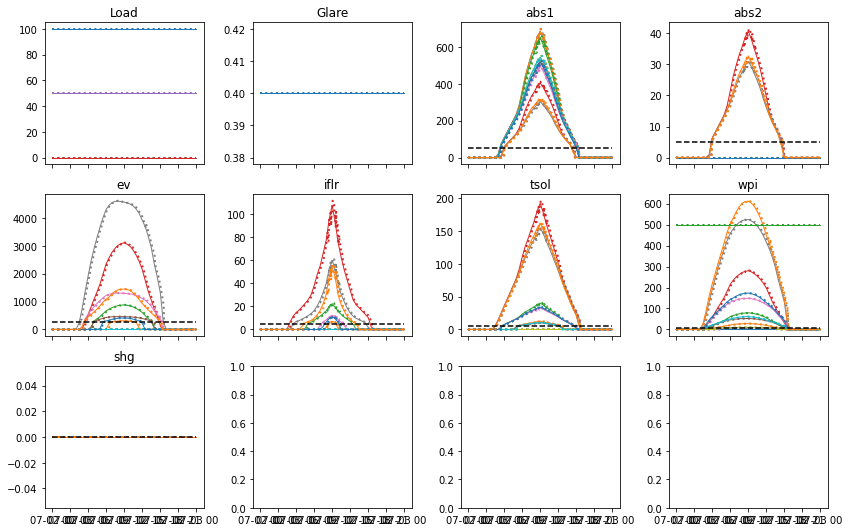

In [63]:
test = resample_variable_ts(data.copy(deep=True), reduced_start=60, reduced_ts=30, cols_fill=[])

cols = []
#cols.append(['DHI','DNI'])
#cols.append(['DryBulb','oat','temp_room_max','temp_room_min',
#             'temp_slab_max','temp_slab_min'])
#cols.append(['battery_0_avail','battery_0_demand','battery_reg'])
cols.append(['equipment','generation_pv','load_demand','occupant_load','plug_load'])
cols.append(['glare_max'])
cols.append([c for c in data.columns if 'abs1' in c])
cols.append([c for c in data.columns if 'abs2' in c])
cols.append([c for c in data.columns if 'ev' in c])
cols.append([c for c in data.columns if 'iflr' in c])
cols.append([c for c in data.columns if 'tsol' in c])
cols.append([c for c in data.columns if 'wpi' in c])
cols.append([c for c in data.columns if 'shg' in c])
#title = ['Solar','Temperature','Battery']
title = []
title += ['Load','Glare','abs1','abs2','ev','iflr','tsol','wpi','shg']

rows = int(round(len(cols)/4 + 0.49))
fig, axs = plt.subplots(rows, 4, figsize=(12, rows*2.5), sharex=True, sharey=False)
axs = axs.ravel()
i = 0
for c in cols:
    ci = 0
    for k in c:
        axs[i].plot(data[k], color='C{}'.format(ci), linestyle=':', linewidth=2)
        axs[i].plot(test[k], color='C{}'.format(ci), linestyle='-', linewidth=1)
        ci += 1
    if title[i] in parameter['facade']['rad_cutoff'].keys():
        axs[i].plot(test.index, [parameter['facade']['rad_cutoff'][title[i]][0]]*len(test),
                    color='black', linestyle='--')
    axs[i].set_title(title[i])
    i += 1
plt.tight_layout()
plt.show()

In [65]:
var_ts = pd.DataFrame([(24, 5)]+list(itertools.product(range(0, 12+2, 2), [15, 30, 60])),
                      columns=['reduced_start','reduced_ts'])
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_name='',
                 solver_path=solver_path,
                 pyomo_logger=logging.ERROR,
                 output_list=output_list)
for ix in var_ts.index:
    test = resample_variable_ts(data.copy(deep=True),
                                reduced_start=int(var_ts.loc[ix,'reduced_start']*60),
                                reduced_ts=int(var_ts.loc[ix,'reduced_ts']), cols_fill=[])
    test, _ = compute_periods(test, get_e19_2020_tariff(), parameter)
    options = {'seconds': int(1*60)}
    res = smartDER.do_optimization(test, tee=False, options=options, print_error=False)
    duration, objective, df, model, result, termination, parameter = res
    var_ts.loc[ix, 'duration'] = duration
    var_ts.loc[ix, 'energy'] = model.sum_energy_cost.value * parameter['objective']['weight_energy']
    var_ts.loc[ix, 'demand'] = model.sum_demand_cost.value * parameter['objective']['weight_demand']

KeyboardInterrupt: 

In [66]:
var_ts

,reduced_start,reduced_ts,duration,energy,demand
0,24,5,64.651592,9.371875,4.642
1,0,15,58.798481,9.140367,4.642
2,0,30,5.936994,9.017468,4.642
3,0,60,1.343111,8.750870,4.642
4,2,15,61.460893,9.280561,4.642
5,2,30,8.029284,9.017629,4.642
6,2,60,2.457609,8.751221,4.642
7,4,15,48.557593,9.140494,4.642
8,4,30,9.911805,9.017787,4.642
9,4,60,3.318536,8.751568,4.642
